# 알고리즘 트레이딩 실습 2

<a href="https://colab.research.google.com/github/SLCFLAB/Fintech2022/blob/main/AT_Day2-answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 실습 1 복습

In [1]:
!pip install -U finance-datareader

In [2]:
!pip install -U cvxopt

In [3]:
import FinanceDataReader as fdr
print(fdr.__version__)
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cvxopt as opt
from cvxopt import solvers

0.9.33


### To-Do

다음의 조건에 해당하는 각 지수별 price data를 pandas의 DataFrame 형태로 생성하고 a라는 이름으로 선언하시오.      
https://financedata.github.io/posts/finance-data-reader-users-guide.html
* 조건 1: 각 row의 인덱스는 날짜, 각 컬럼은 KOSPI200 지수, S&P500 지수, 나스닥 지수, 닛케이225 선물, USD/KRW로 구성.
* 조건 2: 종가 기준, 기간은 2010년 이후 현재까지.

In [4]:
symbols = ['KS200', 'US500', 'IXIC', 'JP225', 'USD/KRW']

a = {}
for symbol in symbols:
    print(symbol)
    a[symbol] = fdr.DataReader(symbol, '2010')['Close']

a = pd.DataFrame(a)

KS200
US500
IXIC
JP225
USD/KRW


### Efficient Frontier 구하기

In [5]:
holding_periods=1
n_term=252 # dailiy return을 annualize
data = a

returns = data.pct_change(holding_periods).iloc[holding_periods:] # holding period return vector
exp_rets = returns.mean() * n_term # average return -- > APR(annual percentage rate)
cov_mat = returns.cov() * n_term # covariance
corr_mat = returns.corr() # corr

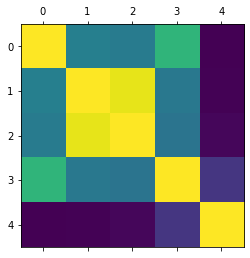

In [6]:
plt.matshow(corr_mat)
plt.show()

<AxesSubplot:>

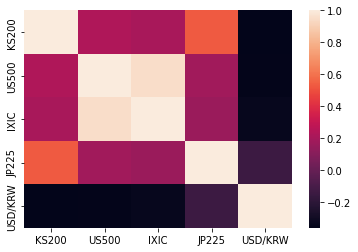

In [7]:
import seaborn as sns

sns.heatmap(corr_mat)

Mean Variance Portfolio를 구성

In [8]:
def mean_var_portfolio(cov_mat, exp_rets, target_ret):
    
    n = len(cov_mat)

    # Objective function
    # min (1/2)*w.T*P*w
    P = opt.matrix(cov_mat.values) 
    q = opt.matrix(0.0, (n, 1))


    # Constraints Gw <= h
    # exp_rets*w >= target_ret and w >= 0
    G = opt.matrix(np.vstack((-exp_rets.values, -np.identity(n))))
    h = opt.matrix(np.vstack((-target_ret, np.zeros((n, 1)))))

    # Constraints Aw = b
    # sum(w) = 1
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Solve
    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, h, A, b)

    # Put weights into a labeled series
    w = pd.Series(sol['x'], index=cov_mat.index)

    return w

In [9]:
max_risk=0.5
max_ret = exp_rets.max()
min_ret = exp_rets[exp_rets > 0].min()

n_step = 100
step_diff = (max_ret - min_ret)/n_step

risks = []
rets = []

for step in range(0, n_step+1):
    target_ret = min_ret + (step * step_diff) # y축을 아래부터 시작해서 위로 조금씩 올려가면서
    _w = mean_var_portfolio(cov_mat, exp_rets, target_ret) # 최적화를 돌려서 나온 _w임.
    risk = np.sqrt(np.dot(np.dot(_w, cov_mat), _w))

    if risk > max_risk:
        break

    risks.append(risk)
    ret = np.dot(exp_rets, _w)
    rets.append(ret)

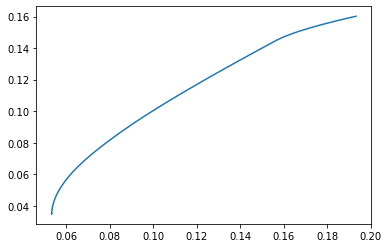

In [10]:
plt.plot(risks, rets)
plt.show()

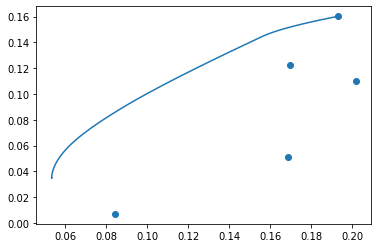

In [11]:
plt.plot(risks, rets)

var = np.diag(cov_mat)
plt.scatter(np.sqrt(var), exp_rets)

plt.show()

### To-do

개미투자자 A는 인덱스에 투자하는 것보다 개별 종목에 투자하는 것을 선호한다. 한국 주식보다는 미국 주식에 투자하는 것을 선호하는 A는 평소 Warren Buffett을 굉장히 존경해왔다고 한다. 최근 뉴스를 보고 Buffett이 관심을 가졌던 주식들을 파악한 A는 다음과 같은 회사들로 포트폴리오를 구성하려 한다.
* Apple
* Occidental Petroleum
* Coca Cola
* Exxon Mobil
* Microsoft

하지만 주변 사람들의 조언을 들어본 결과, 주식으로만 포트폴리오를 구성하는 것은 위험하다고 판단이 든 A는 자신의 포트폴리오에 금(선물)을 포함하기로 결정했다. 총 6개의 종목으로 포트폴리오를 구성한 A에게 도움을 주기 위한 Efficient Frontier를 그려보자

위의 조건에 해당하는 종목들에 대하여 2016년 이후 종가기준으로 dataframe을 생성하고 Efficient Frontier를 그려보시오.

In [13]:
b_symbols = ['AAPL', 'OXY', 'KO', 'XOM', 'MSFT', 'ZG']

b = {}
for symbol in b_symbols:
    print(symbol)
    b[symbol] = fdr.DataReader(symbol, '2016')['Close']

b = pd.DataFrame(b)

AAPL
OXY
KO
XOM
MSFT
ZG


In [14]:
holding_periods=1
n_term=252 # dailiy return을 annualize

b_returns = b.pct_change(holding_periods).iloc[holding_periods:] # holding period return vector
b_exp_rets = b_returns.mean() * n_term # average return -- > APR(annual percentage rate)
b_cov_mat = b_returns.cov() * n_term # covariance
b_corr_mat = b_returns.corr() # corr

In [15]:
max_risk=0.5
b_max_ret = b_exp_rets.max()
b_min_ret = b_exp_rets[b_exp_rets > 0].min()

n_step = 100
step_diff = (b_max_ret - b_min_ret)/n_step

b_risks = []
b_rets = []

for step in range(0, n_step+1):
    target_ret = b_min_ret + (step * step_diff) # y축을 아래부터 시작해서 위로 조금씩 올려가면서
    _w = mean_var_portfolio(b_cov_mat, b_exp_rets, target_ret) # 최적화를 돌려서 나온 _w임.
    risk = np.sqrt(np.dot(np.dot(_w, b_cov_mat), _w))

    if risk > max_risk:
        break

    b_risks.append(risk)
    ret = np.dot(b_exp_rets, _w)
    b_rets.append(ret)

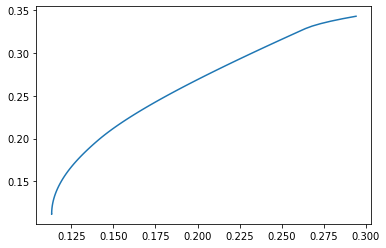

In [16]:
plt.plot(b_risks, b_rets)
plt.show()

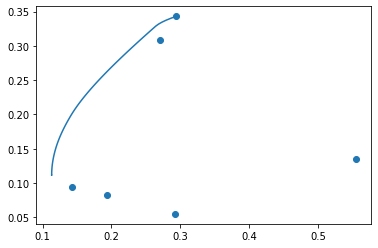

In [17]:
plt.plot(b_risks, b_rets)

b_var = np.diag(b_cov_mat)
plt.scatter(np.sqrt(b_var), b_exp_rets)

plt.show()

In [18]:
for ticker, var in zip(b_symbols, b_var):
    print(ticker, np.sqrt(var), sep=': ')

AAPL: 0.29431901580414577
OXY: 0.5549437420484504
KO: 0.19302221914040377
XOM: 0.29247856140530853
MSFT: 0.27041320131972924
ZG: 0.14277898588314392


<AxesSubplot:xlabel='Date'>

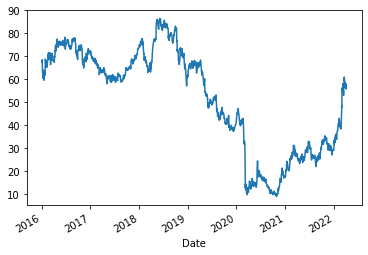

In [19]:
b.OXY.plot()

## 최소 분산 포트폴리오
![](https://ift.world/wp-content/uploads/2018/06/wsi-imageoptim-1-1.png)

**최소 분산 포트폴리오** : 자산들로 구성되는 포트폴리오 중 최소 분산을 갖는 포트폴리오.    
Efficient Frontier 상에서 분산이 가장 작은 점이 된다.

### To-Do

#### A. 앞서 구한 Efficient Frontier를 바탕으로, Efficient frontier 상에서 variance가 가장 작은 점을 구하시오. 

In [20]:
# Efficient Frontier

max_risk=0.5
max_ret = exp_rets.max()
min_ret = exp_rets[exp_rets > 0].min()

n_step = 1000
step_diff = (max_ret - min_ret)/n_step

risks = []
rets = []
weights = []

for step in range(n_step):
    target_ret = min_ret + (step * step_diff) # y축을 아래부터 시작해서 위로 조금씩 올려가면서
    _w = mean_var_portfolio(cov_mat, exp_rets, target_ret) # 최적화를 돌려서 나온 _w임.
    risk = np.sqrt(np.dot(np.dot(_w, cov_mat), _w))

    if risk > max_risk:
        break
    
    risks.append(risk)
    ret = np.dot(exp_rets, _w)
    rets.append(ret)
    weights.append(_w)

min_risk_idx = np.argmin(risks)

#### B. 구한 minimum variance portfolio의 risk, return, portfolio weight를 프린트하시오.

In [21]:
min_risk_idx = np.argmin(risks)
min_risk = risks[min_risk_idx] #np.array(risks).min()
min_risk_ret = rets[min_risk_idx]
min_risk_weight = weights[min_risk_idx]
print("Risk of minimum variance portfolio : ", min_risk)
print("Return of minimum variance portfolio : ", min_risk_ret)
print("Weight of minimum variance portfolio : ")
print(min_risk_weight)

Risk of minimum variance portfolio :  0.053266449932985134
Return of minimum variance portfolio :  0.03483131111149781
Weight of minimum variance portfolio : 
KS200      1.767271e-01
US500      1.714977e-01
IXIC       9.071167e-07
JP225      1.412306e-03
USD/KRW    6.503620e-01
dtype: float64


#### C. Efficient frontier와 Minimum variance portfolio를 plotting하시오.

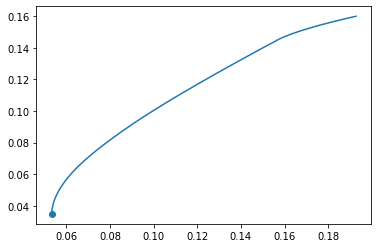

In [22]:
plt.plot(risks, rets)
plt.scatter(min_risk, min_risk_ret)
plt.show()

## 탄젠시 포트폴리오(Tangency Portfolio)

![](https://www.researchgate.net/profile/Teodosii_Rachev/publication/24071755/figure/fig2/AS:667097013161996@1536059730503/The-Efficient-frontier-and-the-tangent-portfolio.png)

앞서서는 주어진 자산들로 구성되는 포트폴리오들을 분석하여 efficient frontier를 구하고, minimum variance portfolio를 구하는 방법을 살펴보았다.     
이제 앞선 구성자산들에 더하여, risk-free asset이 존재할 시 어떤 portfolio들을 만들 수 있는 지 알아보자.
* Risk free asset : 한국의 경우 국고채 3년 금리 사용 --> 1%
* Efficient frontier 상의 포트폴리오 중, Sharpe ratio가 가장 큰 포트폴리오 --> Tangency portfolio

### To-Do

#### 앞서 구한 Efficient Frontier를 바탕으로, Efficient frontier 상에서 Sharpe ratio가 가장 커지는 tangency portfolio 점을 구하시오.

In [23]:
# Efficient Frontier

max_risk=0.5
max_ret = exp_rets.max()
min_ret = exp_rets[exp_rets > 0].min()

n_step = 100
step_diff = (max_ret - min_ret)/n_step

risks = []
rets = []
weights = []

for step in range(n_step):
    target_ret = min_ret + (step * step_diff) # y축을 아래부터 시작해서 위로 조금씩 올려가면서
    _w = mean_var_portfolio(cov_mat, exp_rets, target_ret) # 최적화를 돌려서 나온 _w임.
    risk = np.sqrt(np.dot(np.dot(_w, cov_mat), _w))

    if risk > max_risk:
        break
    
    risks.append(risk)
    ret = np.dot(exp_rets, _w)
    rets.append(ret)
    weights.append(_w)


rf_rate = 0.01

slopes = []

# ToDo
for i in range(len(rets)):
    slope_ = (rets[i] - rf_rate) / risks[i]
    slopes.append(slope_)

max_tangency_idx = np.argmax(slopes)
max_tangency = slopes[max_tangency_idx]

#### a) 구한 tangency portfolio의 risk, return, sharpe ratio, portfolio weight를 프린트하시오.

In [24]:
max_tangency_risk = risks[max_tangency_idx]
max_tangency_return = rets[max_tangency_idx]
max_tangency_weight = weights[max_tangency_idx]

print("Risk of tangency portfolio : ", max_tangency_risk)
print("Return of tangency portfolio : ", max_tangency_return)
print("Sharpe ratio of tangency portfolio : ", (max_tangency_return - rf_rate) / max_tangency_risk)
print("Weight of minimum variance portfolio : ")
print(max_tangency_weight)

Risk of tangency portfolio :  0.09320200450181923
Return of tangency portfolio :  0.09437157501131857
Sharpe ratio of tangency portfolio :  0.905254940194679
Weight of minimum variance portfolio : 
KS200      1.746287e-04
US500      7.587530e-07
IXIC       4.312282e-01
JP225      2.057295e-01
USD/KRW    3.628669e-01
dtype: float64


#### b) tangency portfolio와 risk-free rate를 연결한 직선과, efficint frontier를 plotting 하시오

In [25]:
min_risk_ret

0.03483131111149781

In [26]:
print((min_risk_ret - rf_rate) / min_risk)
print(min_risk_weight)

0.46617169236429756
KS200      1.767271e-01
US500      1.714977e-01
IXIC       9.071167e-07
JP225      1.412306e-03
USD/KRW    6.503620e-01
dtype: float64


In [27]:
# y = ax + b
# E[r_p] = slope * risk + risk-free rate

ys = []
for i in range(len(risks)):
    ys.append(max_tangency * risks[i] + rf_rate)

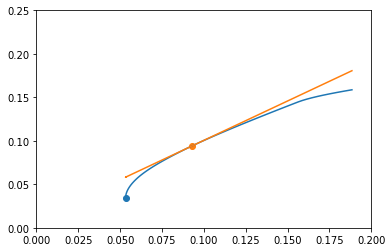

In [28]:
plt.plot(risks, rets)
plt.plot(risks, ys)
plt.scatter(min_risk, min_risk_ret)
plt.scatter(max_tangency_risk, max_tangency_return)
plt.xlim([0, 0.2])
plt.ylim([0, 0.25])
plt.show()

## 백테스팅(Backtesting)

우리가 세운 전략을 **실제로 historical data에 적용**하면 어떻게 되는가?    
먼저 생각해야 할 것.
1) 이전 몇 달 치의 데이터를 사용하여 Tangency portfolio weight를 구성할 것인가? (Lookback period)    
2) **리밸런싱**을 얼마의 주기로 할 것인가?

### 5개 asset으로 tangency portfolio를 구성하는 backtesting

* A) 리밸런싱 시점에서 tangency portfolio를 구성할 때, 이전 6달(120일)의 데이터를 바탕으로 만든다.
* B) 리밸런싱은 3달(60일) 1분기마다 진행한다.
* C) return과 covariance를 구할 때는 월평균으로 구하여 연평균 수익률로 변화시켜준다.
* D) 시작 자산은 10000원에서 시작하여, 각 날짜마다 portfolio value가 어떻게 되는 지를 구한다.

In [29]:
data = a['2015-01-01':]

In [30]:
def create_data(data):
    
    result = data.pct_change(20).iloc[20:]
    
    returns = result
    avg_rets = returns.mean()*12
    cov_mat = returns.cov()*12

    return returns, cov_mat, avg_rets

In [31]:
def mean_var_portfolio(cov_mat, exp_rets, target_ret):
    
    n = len(cov_mat)

    # Objective function
    # min (1/2)*w.T*P*w
    P = opt.matrix(cov_mat.values) 
    q = opt.matrix(0.0, (n, 1))


    # Constraints Gw <= h
    # exp_rets*w >= target_ret and w >= 0
    G = opt.matrix(np.vstack((-exp_rets.values, -np.identity(n))))
    h = opt.matrix(np.vstack((-target_ret, np.zeros((n, 1)))))

    # Constraints Aw = b
    # sum(w) = 1
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Solve
    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, h, A, b)

    # Put weights into a labeled series
    w = pd.Series(sol['x'], index=cov_mat.index)

    return w

In [32]:
def tangency_portfolio(cov_mat, exp_rets, target_ret, min_rets, max_rets, rf_rate = 0.01):
    
    n = len(cov_mat)
    P = opt.matrix(cov_mat.values)
    q = opt.matrix(0.0, (n, 1))
    
    tangency_queue = []
    weights_queue = []
    return_queue = []
    cov_queue = []
    
    step = (max_rets - min_rets)/100
    for i in range(100):
                
        try:
        
            target_ret = min_rets + (i * step)

            # Constraints Gx <= h

            G = opt.matrix(np.vstack((-exp_rets.values, -np.identity(n))))
            h = opt.matrix(np.vstack((-target_ret, np.zeros((n, 1)))))

            # Constraints Ax = b
            # sum(x) = 1
            A = opt.matrix(1.0, (1, n))
            b = opt.matrix(1.0)

            solvers.options['show_progress'] = False
            sol = solvers.qp(P, q, G, h, A, b)

            if sol['status'] != 'optimal':
                pass

            # Put weights into a labeled series
            weights = pd.Series(sol['x'], index=cov_mat.index)
            
            tangency_ = (np.dot(exp_rets, weights) - rf_rate) / np.sqrt(np.dot(np.dot(weights, cov_mat), weights))
            tangency_queue.append(tangency_)
            weights_queue.append(weights)
            return_queue.append(np.dot(exp_rets, weights))
            cov_queue.append(np.sqrt(np.dot(np.dot(weights, cov_mat), weights)))
        
        except:
            pass

    
    tan_index = tangency_queue.index(max(tangency_queue))
    
    weights = weights_queue[tan_index]

    return weights

In [33]:
data = data.dropna()

In [34]:
ret = data.pct_change().iloc[1:]

In [35]:
data.shape

(1634, 5)

In [40]:
def back_test(data, ret):

    # Window_size는 tangency portfolio를 구할 때 이전 몇 달의 데이터를 사용할 것인지 나타낸다.
    total_days = data.shape[0]
    
    # Rebalancing을 한 달마다 진행하는 경우, 'M'으로 rebalance_period는 20이 된다.
    rebalance_period = 60 # 3개월에 한번 = 분기당 한번
    window_size = 120 # 지난 6개월

    returns, cov_mat, avg_rets= create_data(data)
    
    # n_rebalance : 총 몇 번의 리밸런싱을 하게 되는지?
    n_rebalance = (total_days - window_size) // rebalance_period
    w = []
    rebalancing_date=[]
    original_weights = []
    
    rebal = 60
    for i in range(window_size, total_days):
        # 리밸런싱을 할 때 마다 Tangency portfolio weight를 새로 구해야 한다.
        # 이때 리밸런싱 시점 이전의 총 120일 간의 데이터를 사용한다.
        
        if rebal % rebalance_period == 0:
            #print('rebalance')
            _returns, _cov_mat, _avg_rets= create_data(data[(i-window_size):i])
            rebalancing_date.append(data.index[i:i+1]) # rebalance_period 씩 늘려가자
            rebal = 0
            _target_ret = _avg_rets.quantile(0.7)
            _min_ret = _avg_rets.min()
            _max_ret = _avg_rets.max()
            _w = tangency_portfolio(_cov_mat, _avg_rets, _target_ret, _min_ret, _max_ret)
            print(n_rebalance)
            n_rebalance = n_rebalance - 1
            print(_w)
            _w.plot.bar()
            plt.show()
            plt.close()
            _w = np.asarray(_w.values) #np.array([0.0, 0.0, 1.0, 0.0, 0.0])
            w.append(_w)
            

        rebal = rebal + 1
        
    
    price = data
    price = np.array(price)
    
    port = [] # 여기에 날마다 변하는 Portfolio value를 저장한다.
    port_date = [] # 여기에 portfolio의 data를 저장한다.
    portfolio_value = 10000
    port_each_money = [] # 그 날의 portfolio의 구성이다. Ex) 만약 Asset1에 6000원, Asset2에 4000원, 나머지에 0원이 있다면 [6000, 4000, 0, 0, 0]이 된다.
    
    rebal = 60
    j = 0
    for i in range(window_size, total_days):
        
        if i == window_size: # 초기화
            port_each_money = portfolio_value * w[j]
            rebal = 1
            # port_each_money 값을 다 더한 게 그 날의 portfolio_value가 된다.
            portfolio_value = port_each_money.sum()
            # port에 portfolio_value를 저장하여 준다.
            port.append(portfolio_value)
            j = j+1


        else:
            #각 날마다 자산의 가격이 바뀌므로, port_each_money 변화한다.
            port_each_money = port_each_money * (1+ret.iloc[i])
            portfolio_value = port_each_money.sum()
            if rebal % rebalance_period == 0:
                rebal = 0
                # 리밸런싱을 하는 날이다. Portfolio value를 새로운 tangency portfolio weight로 맞춰준다.
                port_each_money = portfolio_value * w[j]
                # port_weight의 값을 다 더한 게 그 날의 portfolio_value가 된다.
                portfolio_value = port_each_money.sum()
                # port에 portfolio_value를 저장하여 준다.
                port.append(portfolio_value)
                j = j+1
            
            else:
                # 리밸런싱 날짜가 아닌 평범함 날짜. 
                # port_each_money 값을 다 더한 게 그 날의 portfolio_value가 된다.
                portfolio_value = port_each_money.sum()
                # port에 portfolio_value를 저장하여 준다.
                port.append(portfolio_value)
            
        rebal = rebal + 1
        port_date.append(data.index[i:i+1][0])
    
    portfolio = pd.DataFrame(port, columns = ['portfolio_value'], index = port_date)
    
    return w, portfolio, rebalancing_date

In [41]:
data

,KS200,US500,IXIC,JP225,USD/KRW
Date,,,,,
2015-01-05,244.26,2020.58,4652.57,17408.71,1109.93
2015-01-06,239.93,2002.61,4592.74,16883.19,1099.00
2015-01-07,240.53,2025.90,4650.47,16885.33,1098.74
2015-01-08,243.94,2062.14,4736.19,17167.10,1095.51
2015-01-09,246.05,2044.81,4704.07,17197.73,1085.82
...,...,...,...,...,...
2022-03-31,365.61,4530.41,14220.52,27821.43,1214.17
2022-04-01,363.19,4545.86,14261.50,27665.98,1219.73
2022-04-04,364.94,4582.64,14532.55,27736.47,1213.75


In [42]:
ret

,KS200,US500,IXIC,JP225,USD/KRW
Date,,,,,
2015-01-06,-0.017727,-0.008893,-0.012860,-0.030187,-0.009847
2015-01-07,0.002501,0.011630,0.012570,0.000127,-0.000237
2015-01-08,0.014177,0.017888,0.018433,0.016687,-0.002940
2015-01-09,0.008650,-0.008404,-0.006782,0.001784,-0.008845
2015-01-13,0.000975,-0.010651,-0.009050,-0.006397,-0.006484
...,...,...,...,...,...
2022-03-31,0.003045,-0.015653,-0.015355,-0.007344,0.003189
2022-04-01,-0.006619,0.003410,0.002882,-0.005587,0.004579
2022-04-04,0.004818,0.008091,0.019006,0.002548,-0.004903


25
KS200      1.933351e-07
US500      2.044298e-06
IXIC       5.809639e-06
JP225      9.888570e-01
USD/KRW    1.113491e-02
dtype: float64


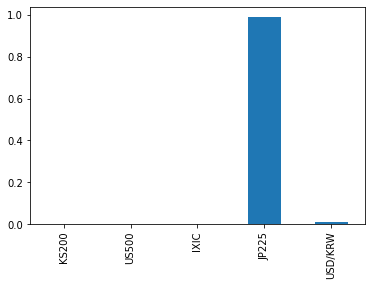

24
KS200      9.999316e-03
US500      4.242405e-07
IXIC       4.542954e-07
JP225      5.328906e-08
USD/KRW    9.899998e-01
dtype: float64


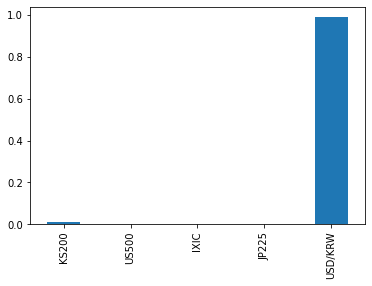

23
KS200      2.374837e-02
US500      6.706289e-07
IXIC       4.783397e-07
JP225      8.964407e-08
USD/KRW    9.762504e-01
dtype: float64


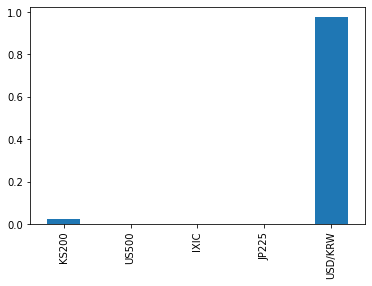

22
KS200      1.624693e-07
US500      7.320517e-01
IXIC       5.879729e-08
JP225      9.222597e-09
USD/KRW    2.679481e-01
dtype: float64


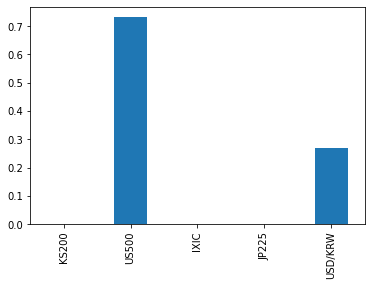

21
KS200      3.970978e-08
US500      9.099997e-01
IXIC       2.436227e-07
JP225      5.750990e-08
USD/KRW    8.999991e-02
dtype: float64


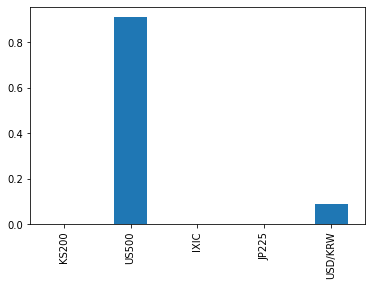

20
KS200      0.671479
US500      0.000003
IXIC       0.156777
JP225      0.000002
USD/KRW    0.171739
dtype: float64


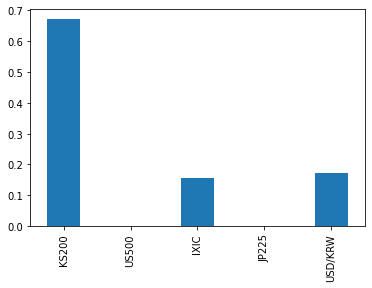

19
KS200      4.364541e-04
US500      1.086713e-07
IXIC       6.187994e-01
JP225      9.888080e-02
USD/KRW    2.818833e-01
dtype: float64


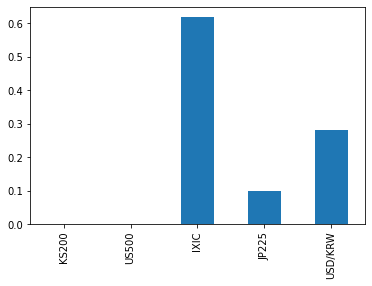

18
KS200      3.388398e-01
US500      1.951800e-06
IXIC       6.611576e-01
JP225      2.942518e-08
USD/KRW    6.032808e-07
dtype: float64


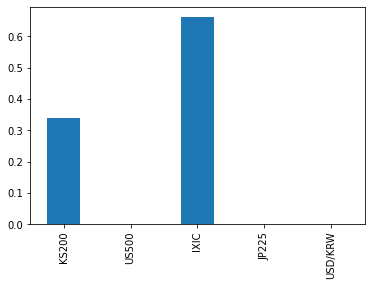

17
KS200      0.325506
US500      0.000076
IXIC       0.317783
JP225      0.000002
USD/KRW    0.356634
dtype: float64


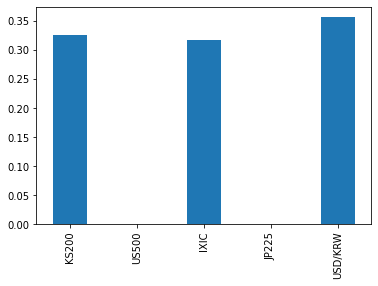

16
KS200      2.147922e-07
US500      2.350822e-01
IXIC       4.900037e-01
JP225      5.684662e-06
USD/KRW    2.749082e-01
dtype: float64


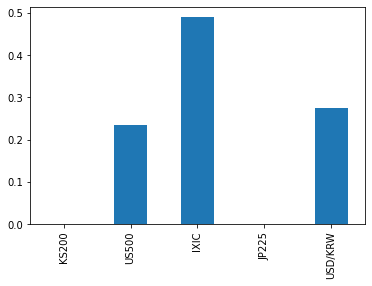

15
KS200      9.614527e-07
US500      3.890893e-06
IXIC       9.899958e-01
JP225      1.085713e-06
USD/KRW    9.998293e-03
dtype: float64


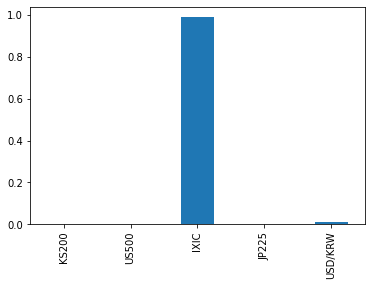

14
KS200      2.352398e-07
US500      3.528062e-07
IXIC       6.302291e-01
JP225      3.349982e-07
USD/KRW    3.697700e-01
dtype: float64


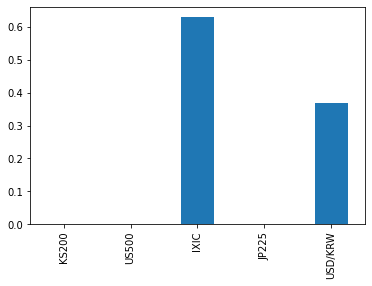

13
KS200      7.992712e-06
US500      4.800128e-01
IXIC       1.881359e-07
JP225      8.233990e-02
USD/KRW    4.376392e-01
dtype: float64


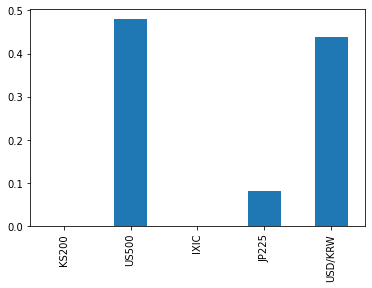

12
KS200      3.852012e-07
US500      1.951691e-02
IXIC       4.011304e-07
JP225      5.505418e-07
USD/KRW    9.804818e-01
dtype: float64


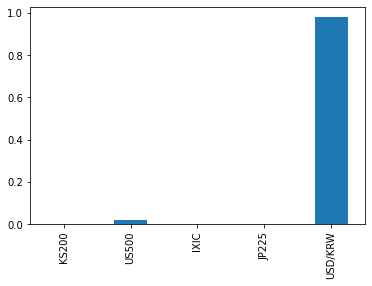

11
KS200      1.454169e-07
US500      4.417336e-07
IXIC       1.904380e-01
JP225      1.268295e-08
USD/KRW    8.095614e-01
dtype: float64


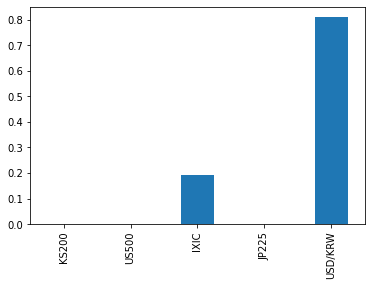

10
KS200      0.000036
US500      0.409378
IXIC       0.000001
JP225      0.000009
USD/KRW    0.590576
dtype: float64


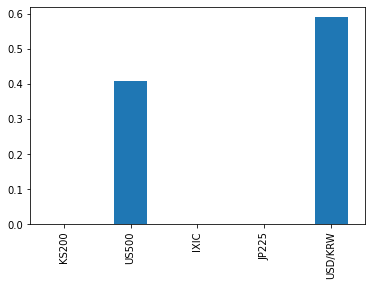

9
KS200      5.515338e-02
US500      3.177838e-01
IXIC       5.465732e-07
JP225      7.015233e-04
USD/KRW    6.263607e-01
dtype: float64


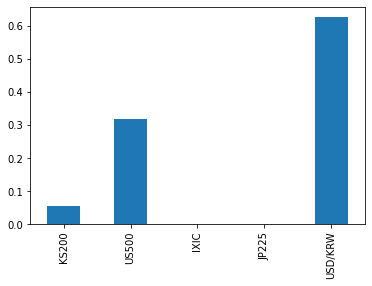

8
KS200      0.011038
US500      0.000007
IXIC       0.281924
JP225      0.232474
USD/KRW    0.474557
dtype: float64


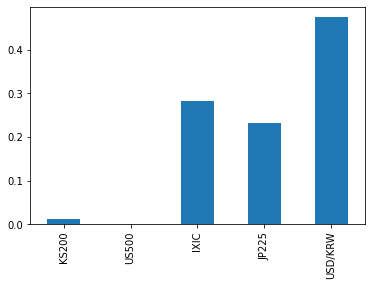

7
KS200      8.395387e-03
US500      1.040590e-06
IXIC       1.002127e-01
JP225      8.923757e-07
USD/KRW    8.913900e-01
dtype: float64


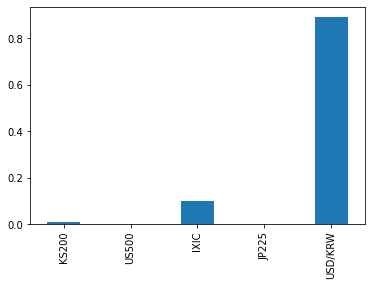

6
KS200      4.521513e-06
US500      6.987930e-07
IXIC       1.899980e-01
JP225      9.162743e-07
USD/KRW    8.099959e-01
dtype: float64


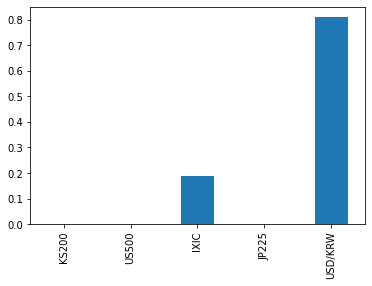

5
KS200      2.328219e-01
US500      1.179404e-07
IXIC       4.603676e-01
JP225      3.068103e-01
USD/KRW    7.576789e-08
dtype: float64


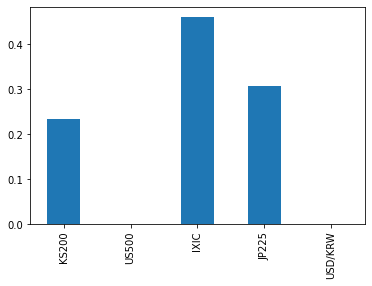

4
KS200      8.672586e-02
US500      1.319723e-07
IXIC       2.963645e-01
JP225      6.169090e-01
USD/KRW    5.247964e-07
dtype: float64


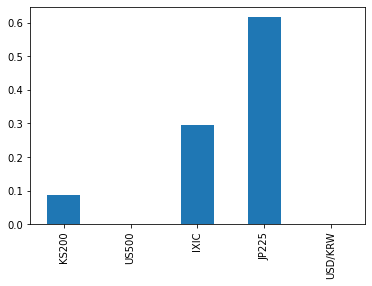

3
KS200      0.016289
US500      0.432302
IXIC       0.000009
JP225      0.000020
USD/KRW    0.551381
dtype: float64


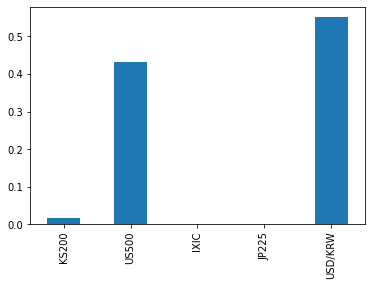

2
KS200      4.324450e-03
US500      5.078914e-01
IXIC       5.277142e-07
JP225      2.833063e-06
USD/KRW    4.877808e-01
dtype: float64


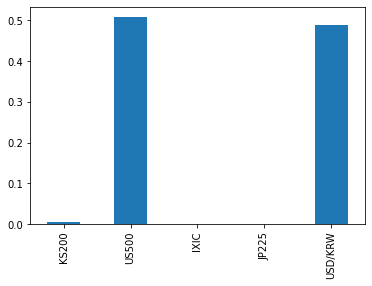

1
KS200      0.000005
US500      0.281578
IXIC       0.000002
JP225      0.017760
USD/KRW    0.700655
dtype: float64


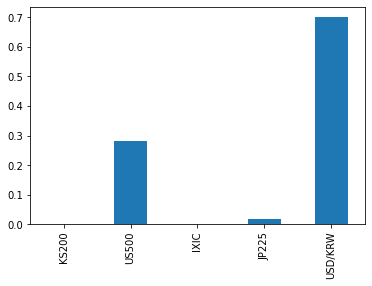

0
KS200      2.934469e-08
US500      8.167512e-02
IXIC       3.581588e-08
JP225      2.405994e-08
USD/KRW    9.183248e-01
dtype: float64


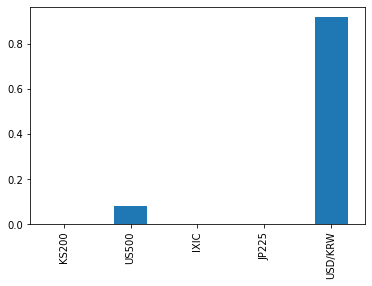

In [43]:
w, portfolio, rebalancing_date = back_test(data[1:], ret)

<AxesSubplot:>

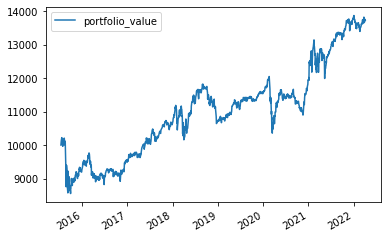

In [44]:
portfolio.plot()

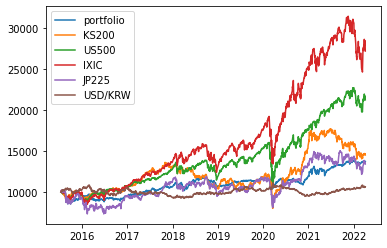

In [45]:
# Backtest Result Plotting
plt.plot(portfolio, label="portfolio")

for symbol in ['KS200', 'US500', 'IXIC', 'JP225', 'USD/KRW']:
    plt.plot(data[121:][symbol] * 10000 / data[121:][symbol][0], label='{}'.format(symbol))

plt.legend()
plt.show()

### To-Do

#### 앞서 구한 리밸런싱 포트폴리오의 Sharpe ratio를 plot 하시오.

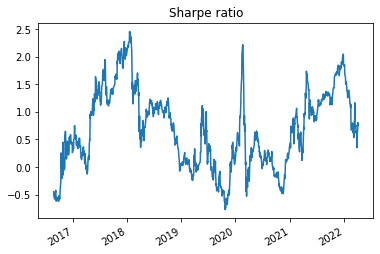

In [46]:
# Sharpe Ratio 계산

new_port = portfolio
new_port['returns'] = new_port['portfolio_value'].pct_change(1)

# Input y에 대해 Sharpe ratio를 구해주는 함수. Sharpe ratio = mean / std 를 연환산해주면 된다.
def my_rolling_sharpe(y):
    rf_rate = 0.01
    return (y.mean()*252 - rf_rate) / (y.std()*np.sqrt(252))

# Calculate rolling Sharpe ratio
new_port['rs'] = new_port['returns'].rolling(252).apply(my_rolling_sharpe)

new_port['rs'][252:].plot()
plt.title('Sharpe ratio')
plt.show()

## Backtest with A's portfolio

다른 포트폴리오 유니버스에 대한 백테스팅을 진행해보자. 앞서 생성한 투자자 A의 데이터프레임을 바탕으로 동일한 전략에 대한 백테스팅을 진행해보자. 최종적인 시간에 따른 수익 변화를 plot하시오.

In [47]:
b_data = b.dropna()

In [48]:
b_ret = b_data.pct_change().iloc[1:]

19
AAPL    2.151903e-06
OXY     1.781185e-08
KO      1.221096e-07
XOM     7.632202e-01
MSFT    1.435179e-01
ZG      9.325964e-02
dtype: float64


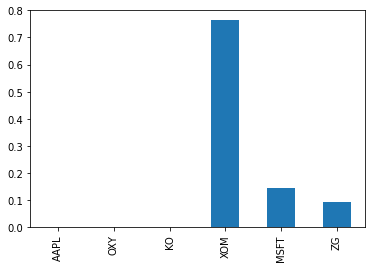

18
AAPL    4.945329e-01
OXY     4.942883e-07
KO      6.306826e-07
XOM     1.667171e-01
MSFT    1.302439e-01
ZG      2.085049e-01
dtype: float64


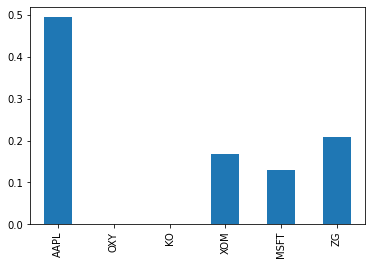

17
AAPL    2.480160e-01
OXY     1.661495e-08
KO      3.627084e-08
XOM     1.090821e-07
MSFT    7.519838e-01
ZG      4.160322e-08
dtype: float64


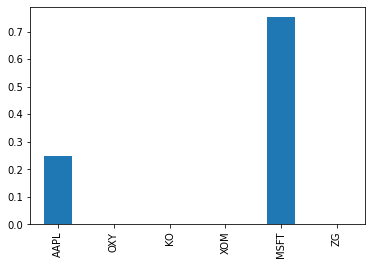

16
AAPL    0.121720
OXY     0.000003
KO      0.361545
XOM     0.000004
MSFT    0.367661
ZG      0.149068
dtype: float64


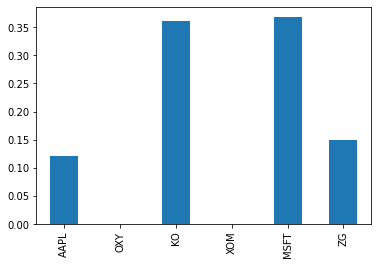

15
AAPL    0.000002
OXY     0.054162
KO      0.000732
XOM     0.000007
MSFT    0.828915
ZG      0.116182
dtype: float64


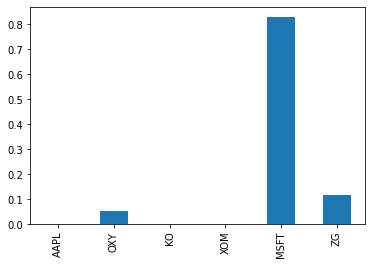

14
AAPL    2.145784e-05
OXY     2.374623e-01
KO      1.709759e-06
XOM     1.891190e-07
MSFT    4.681447e-01
ZG      2.943696e-01
dtype: float64


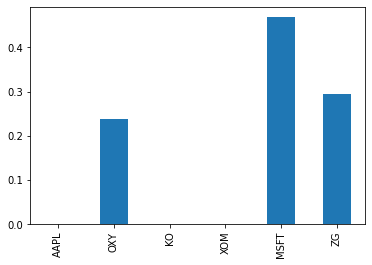

13
AAPL    5.624992e-07
OXY     9.486968e-02
KO      1.357537e-07
XOM     1.494600e-07
MSFT    8.920119e-01
ZG      1.311756e-02
dtype: float64


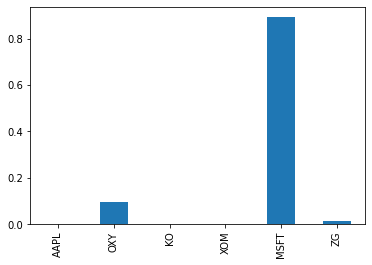

12
AAPL    1.289957e-01
OXY     1.062568e-01
KO      3.741763e-01
XOM     1.652330e-01
MSFT    2.253382e-01
ZG      8.856480e-08
dtype: float64


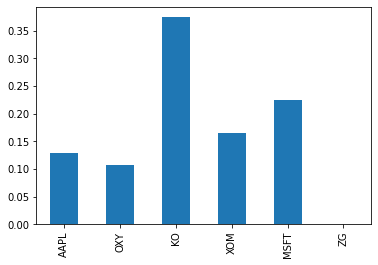

11
AAPL    6.942912e-08
OXY     1.776842e-08
KO      3.350352e-01
XOM     2.860727e-08
MSFT    1.958851e-01
ZG      4.690796e-01
dtype: float64


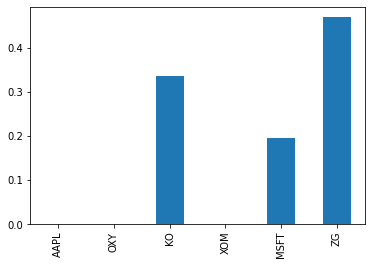

10
AAPL    8.083184e-07
OXY     4.850181e-07
KO      1.355888e-01
XOM     7.777248e-07
MSFT    2.438338e-01
ZG      6.205753e-01
dtype: float64


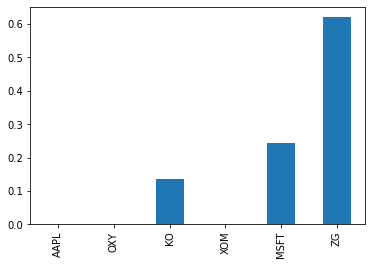

9
AAPL    2.177782e-06
OXY     1.768877e-09
KO      5.981938e-01
XOM     2.165732e-09
MSFT    1.555177e-01
ZG      2.462863e-01
dtype: float64


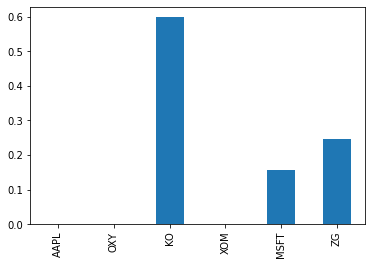

8
AAPL    4.174720e-01
OXY     4.062222e-08
KO      9.659674e-02
XOM     6.100580e-08
MSFT    1.804690e-06
ZG      4.859294e-01
dtype: float64


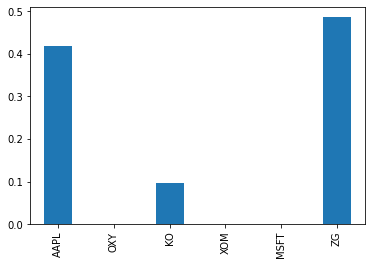

7
AAPL    5.121104e-01
OXY     4.580334e-10
KO      3.456426e-09
XOM     8.456301e-10
MSFT    1.437449e-07
ZG      4.878895e-01
dtype: float64


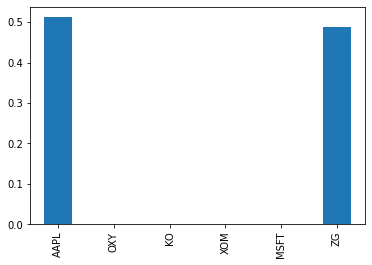

6
AAPL    7.408803e-08
OXY     4.739724e-09
KO      9.133634e-09
XOM     2.279730e-08
MSFT    3.598684e-08
ZG      9.999999e-01
dtype: float64


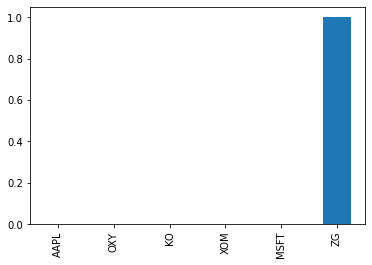

5
AAPL    1.988165e-01
OXY     1.605299e-09
KO      4.013729e-01
XOM     3.881253e-09
MSFT    3.998103e-01
ZG      2.892866e-07
dtype: float64


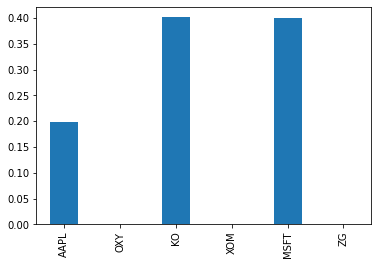

4
AAPL    1.195598e-01
OXY     3.660186e-02
KO      2.968661e-01
XOM     2.422748e-06
MSFT    5.469698e-01
ZG      6.655678e-09
dtype: float64


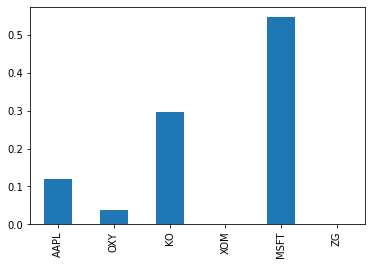

3
AAPL    0.041152
OXY     0.051798
KO      0.143863
XOM     0.127920
MSFT    0.347948
ZG      0.287320
dtype: float64


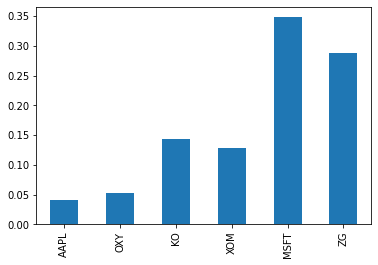

2
AAPL    1.377402e-07
OXY     1.401959e-01
KO      1.505278e-06
XOM     7.865042e-06
MSFT    5.931145e-01
ZG      2.666802e-01
dtype: float64


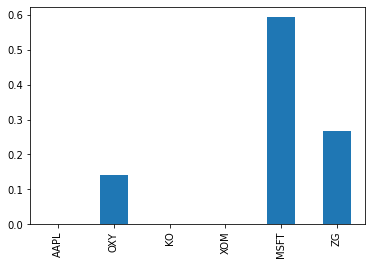

1
AAPL    5.419360e-01
OXY     2.339529e-01
KO      1.114329e-08
XOM     6.498156e-07
MSFT    2.240992e-01
ZG      1.121612e-05
dtype: float64


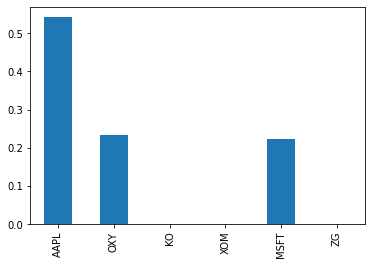

0
AAPL    3.437300e-01
OXY     3.856083e-02
KO      5.123580e-03
XOM     1.598978e-01
MSFT    5.254814e-08
ZG      4.526877e-01
dtype: float64


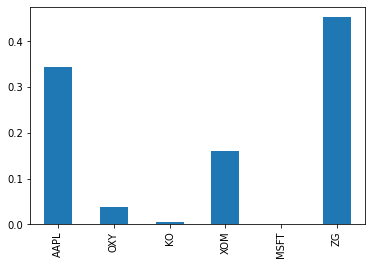

In [49]:
b_w, b_portfolio, b_rebalancing_date = back_test(b_data[1:], b_ret)

<AxesSubplot:>

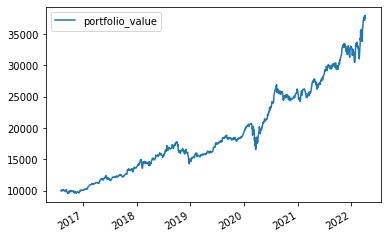

In [50]:
b_portfolio.plot()

Final Value of Portfolio

In [63]:
b_portfolio.values[-1][0]

37549.13728850316

### To-Do

더 좋은 전략이 있을까요? 더 좋은 전략을 구상하시고 백테스팅을 진행해보세요!